In [6]:
%reset -f
# Sheet metal gauge reference: https://armstrongmetalcrafts.com/reference/SheetMetalGaugeWeight.aspx

# Manufacturing capabilities per value stream @ BAC
This code shows conservative boundaries for the allowed dimensions in each manufacturing value stream.

In [7]:
from capabilities import Capabilities
import pandas as pd
import numpy as np
import xlwings as xw
import os
for app in xw.apps: 
    app.quit()

Extracting dimensions from cost calculator. CWB example to start with.

In [8]:
path_e = r"C:\Users\EMedina\OneDrive - Baltimore Aircoil Company\Documents\Co-Op\Enrique + Stanley\Models\Cost\VS Costs\CWB Cost Calculator.xlsx"
path_s = r"C:\Users\ssalim\OneDrive - Baltimore Aircoil Company\Medina, Enrique Flores's files - Enrique + Stanley\Models\Cost\VS Costs\CWB Cost Calculator.xlsx"
path = path_e if os.path.exists(path_e) else path_s
df = pd.read_excel(path, sheet_name='BAC Part List').iloc[1:].reset_index(drop=True)
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)

c:\Users\EMedina\AppData\Local\anaconda3\envs\BAC\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [9]:
def get_parts_by_set(df, part_set):
    if isinstance(part_set, str): part_set = [part_set]
    return df[df['Part Set'].isin(part_set)].copy()

part_sets = []
for part_set in df['Part Set'].dropna().unique(): part_sets.append(get_parts_by_set(df, part_set))
# part_sets.append(get_parts_by_set(df, 'GAC Reference (MPB)'))
# part_sets.append(get_parts_by_set(df, 'GAC Concept (APB + TL)'))

# Plot manufacturing regions per material and gauge

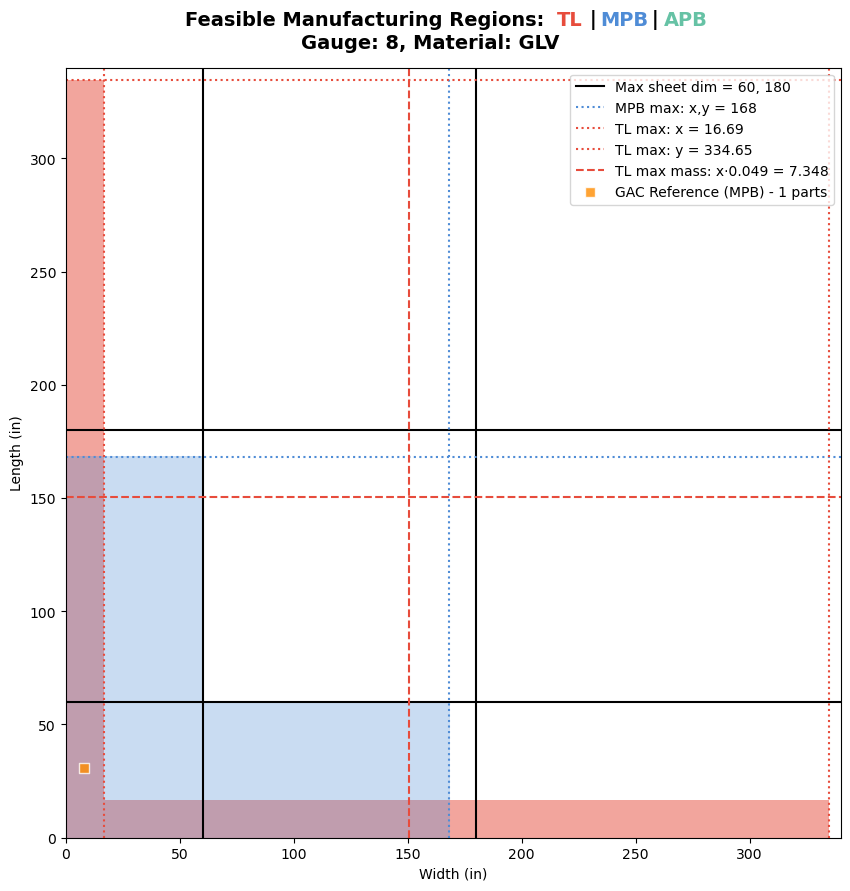

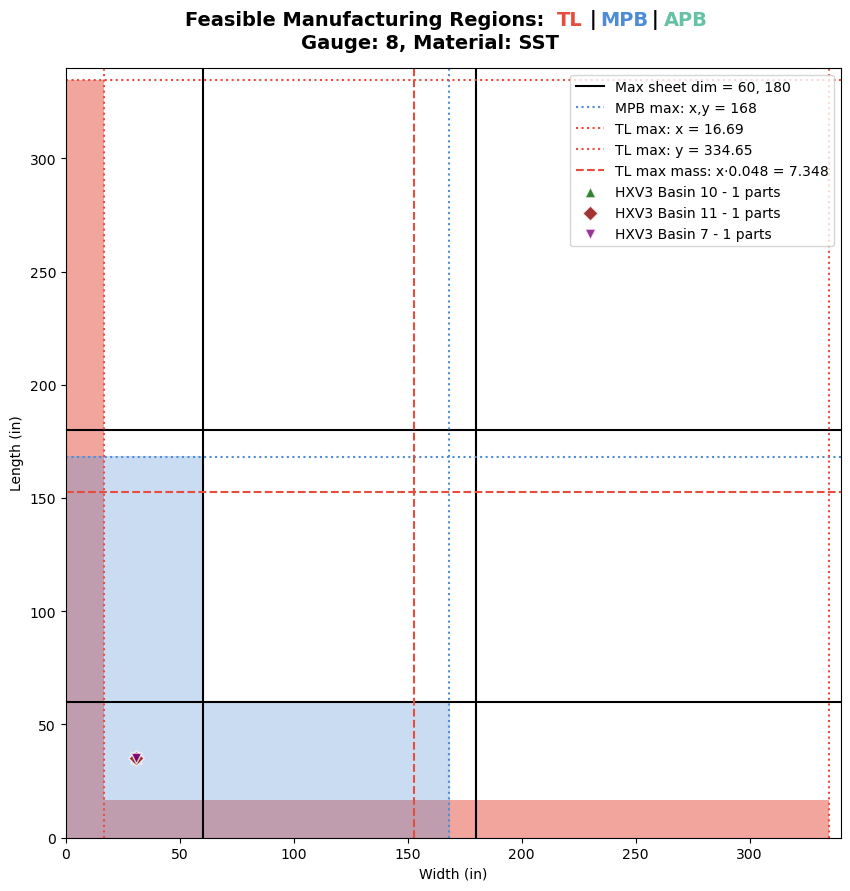

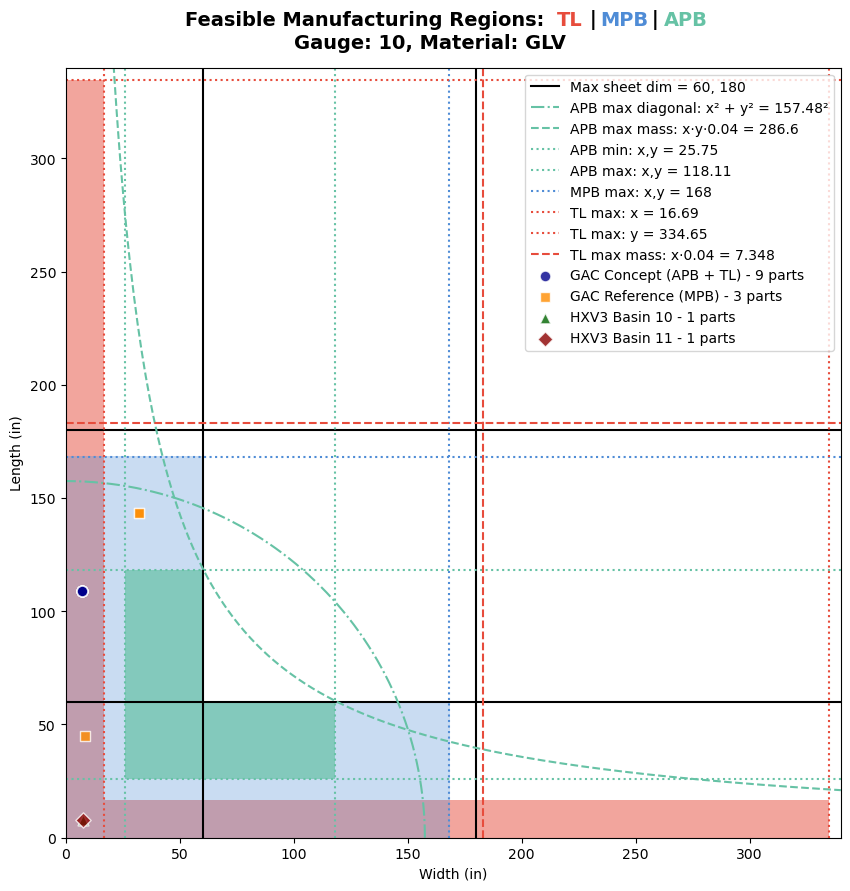

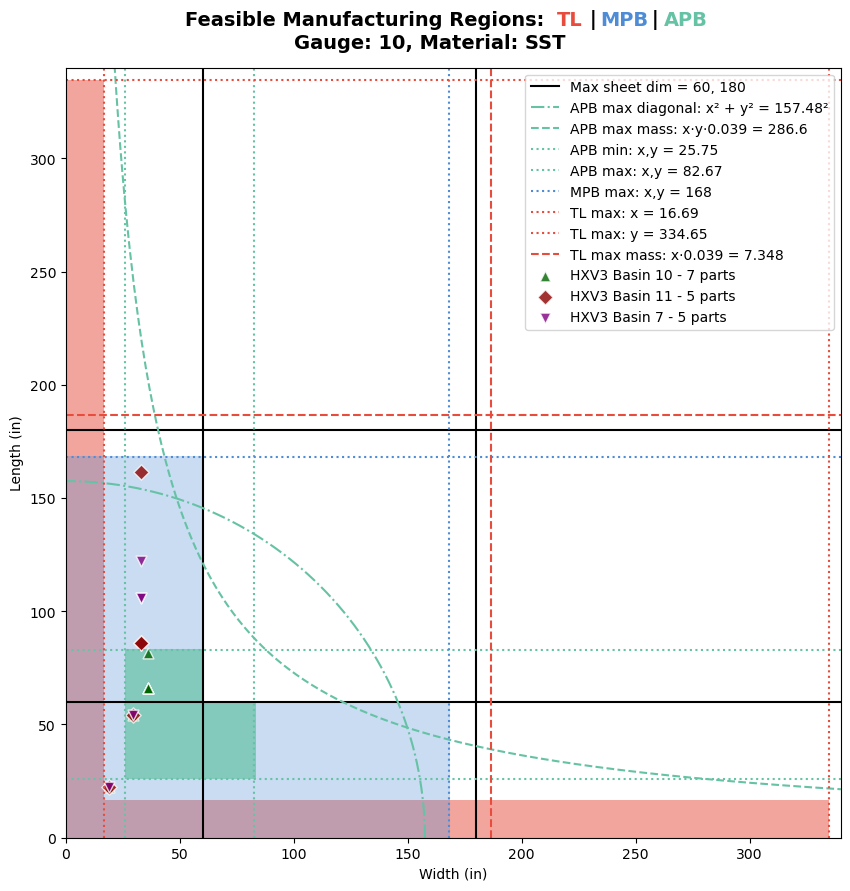

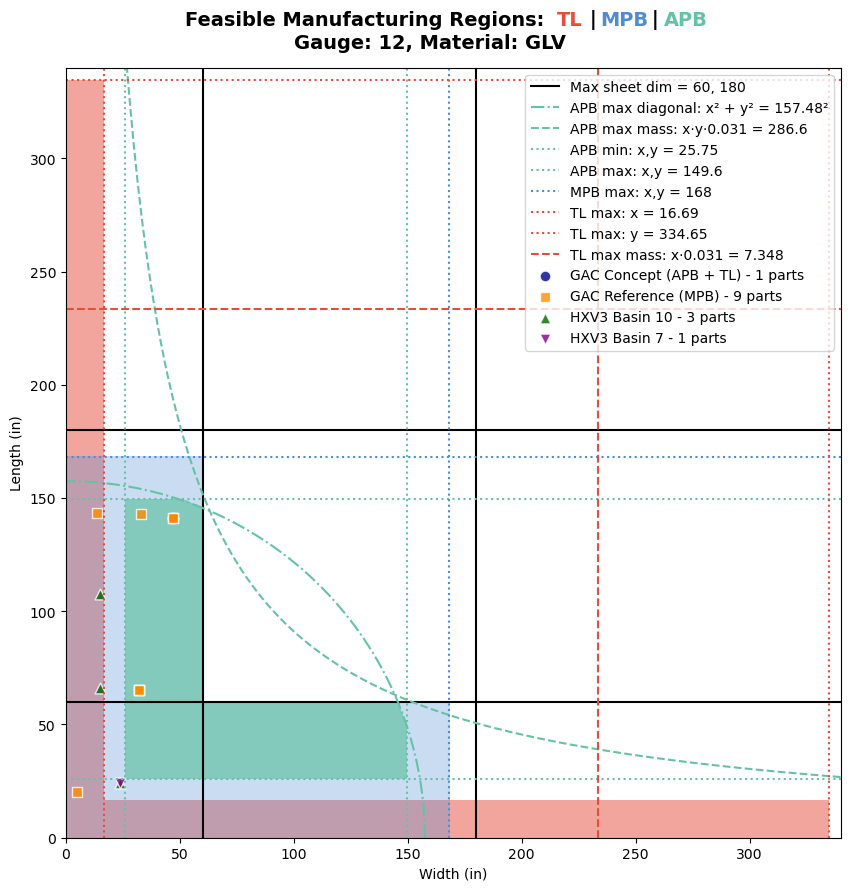

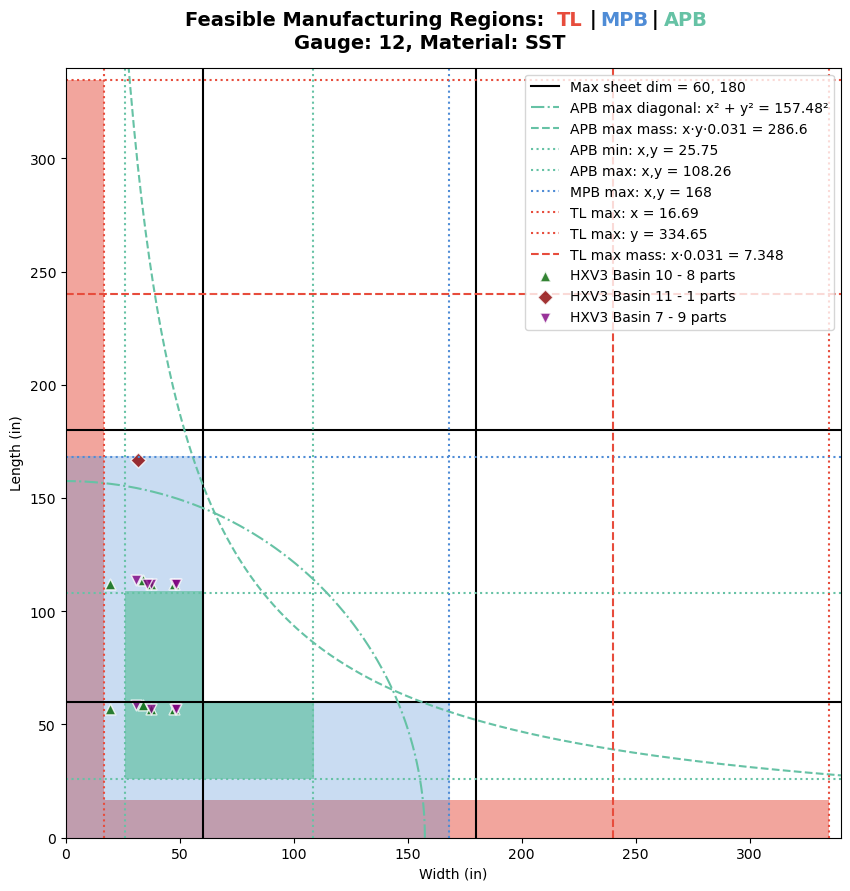

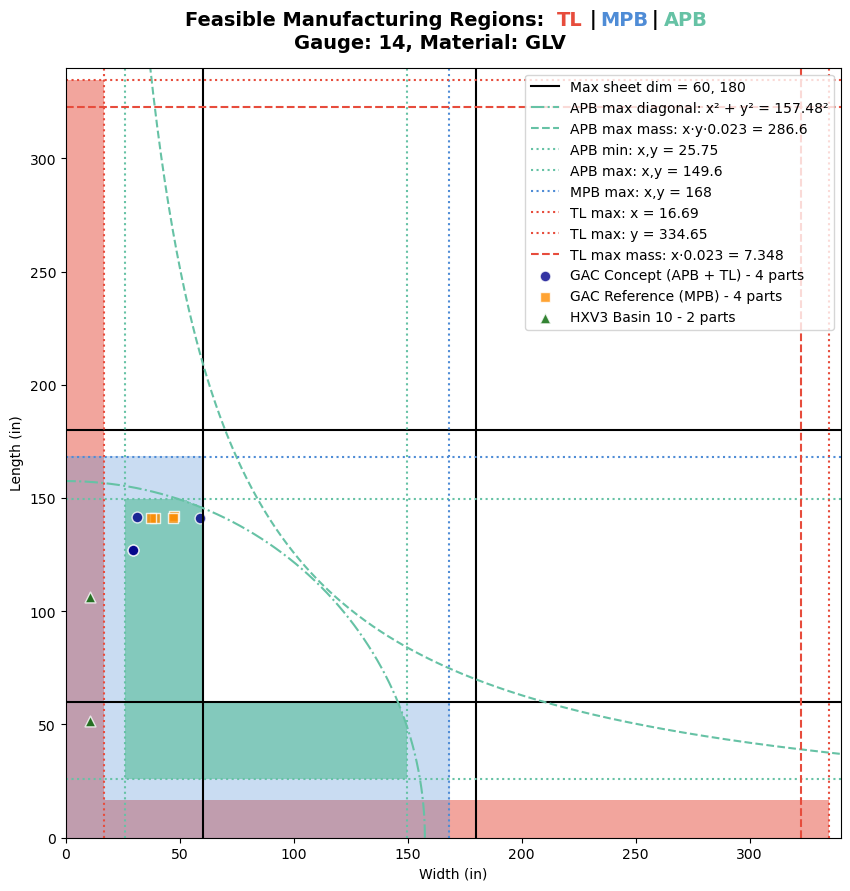

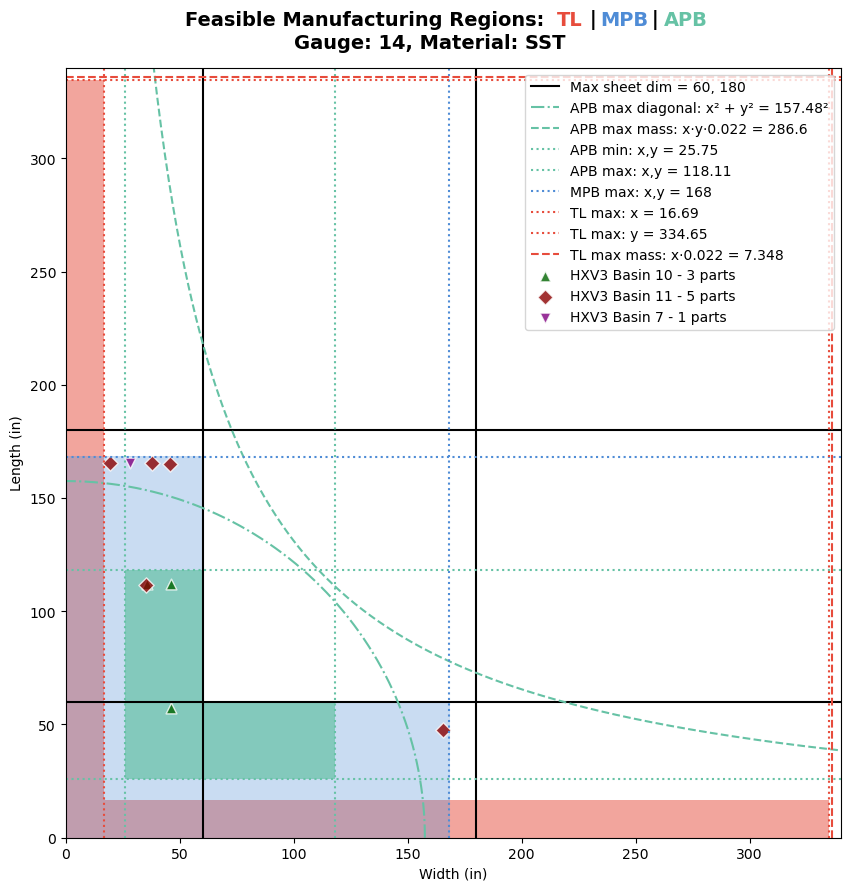

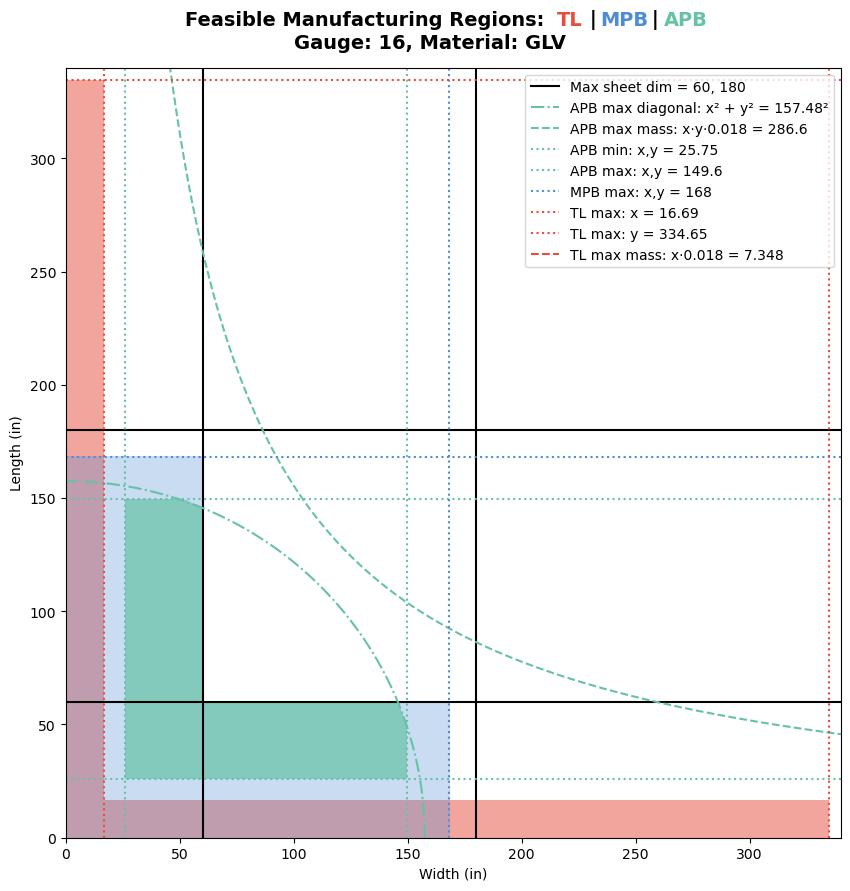

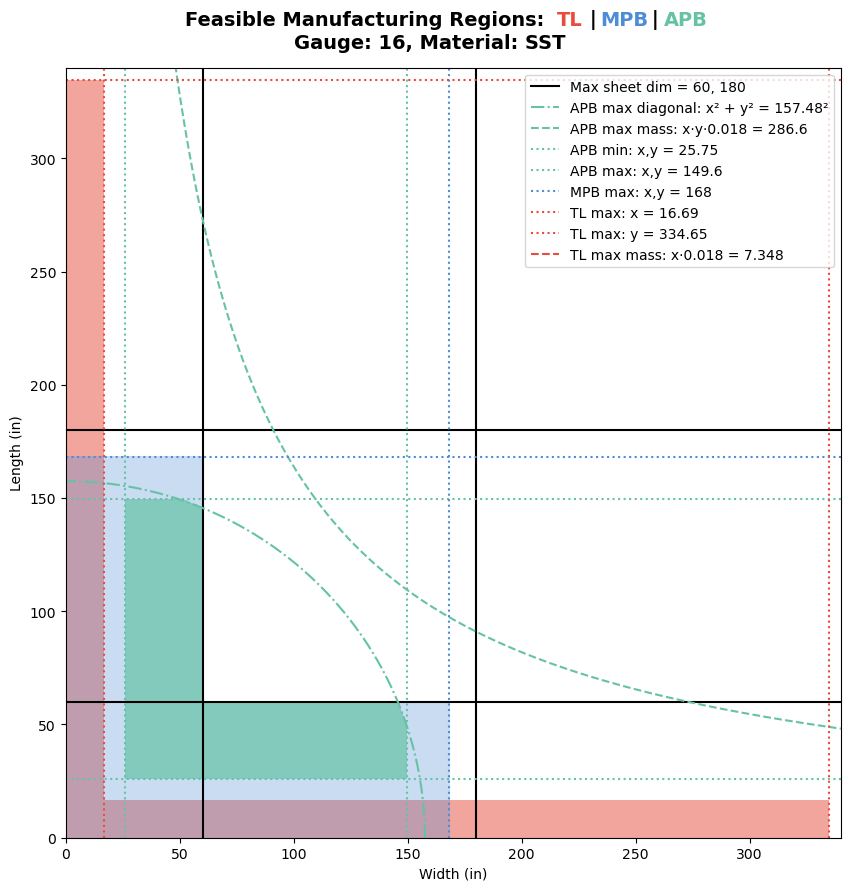

In [10]:
gauges = [8, 10, 12, 14, 16]
materials = ['GLV', 'SST']

# Plot all combinations
for gauge in gauges:
    for material in materials:
        cap = Capabilities(material, gauge)
        cap.plot_feasible_regions()
        cap.add_part_sets(part_sets)

In [11]:
for app in xw.apps:
    app.quit()

# Diagonal increase from (40,30) to (100,80)
# cap = Capabilities('GLV', 10)
# results = cap.plot_cost_run_chart(path, 5, 5, 55, 55, 'diagonal', 5)

# gauges = [8, 10, 12, 14, 16]
# materials = ['GLV', 'SST']
# for gauge in gauges:
#     for material in materials:
#         cap = Capabilities(material, gauge)

#         cap.plot_individual_cost_heatmap(path, fastener_spacing=3, bolt_diameter=0.3125)
#         cap.plot_optimal_cost_heatmap(path, fastener_spacing=3, bolt_diameter=0.3125)
#         cap.plot_cost_difference_heatmap(path, fastener_spacing=3, bolt_diameter=0.3125)